# Previsione della Qualità dell'Aria in India

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo  
**Email:** martin.tomassi@studio.unibo.it , @studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## 1. Caricamento del Dataset

In [5]:
import os
import requests
import zipfile
import io
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from IPython.display import clear_output

N_JOBS = -1
RANDOM_STATE = 42

!apt-get update -qq
!apt-get install -qq git-lfs
!git lfs install
!git clone https://github.com/vMxster/Data_Project.git
!cd Data_Project && git lfs pull

zip_path   = "Data_Project/Datasets/dataset_india.zip"
extract_to = "datasets/india"
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)

print("Estratti:")
for root, _, files in os.walk(extract_to):
    for f in files:
        print(os.path.join(root, f))


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.
fatal: destination path 'Data_Project' already exists and is not an empty directory.
Estratti:
datasets/india/HR004.csv
datasets/india/HR007.csv
datasets/india/UP002.csv
datasets/india/UP012.csv
datasets/india/BR024.csv
datasets/india/RJ007.csv
datasets/india/DL003.csv
datasets/india/MH017.csv
datasets/india/MH015.csv
datasets/india/BR021.csv
datasets/india/BR015.csv
datasets/india/PB004.csv
datasets/india/UP028.csv
datasets/india/DL024.csv
datasets/india/TN014.csv
datasets/india/DL004.csv
datasets/india/KA026.csv
datasets/india/DL023.csv
datasets/india/WB005.csv
datasets/india/GJ013.csv
datasets/india/KA017.csv
datasets/india/DL029.csv
datasets/india/MP004.csv
datasets/india/CG014.csv
datasets/india/HR003.csv
datasets/india/HR023.csv
datasets/india/MH021.csv
datasets/india/AP007

# Dataset sulla **Qualità dell'Aria in India**



Il dataset in questione è stato messo a disposizione dal Central Pollution Control Board (CPCB), l’ente ufficiale del Governo indiano deputato al monitoraggio e alla gestione dell’inquinamento atmosferico, al fine di raccogliere informazioni relative alle condizioni della qualità dell’aria in 453 città indiane nel periodo compreso tra il 2010 e il 2023.

Sempre citando la documentazione ufficiale, il dataset permette di indagare su numerose variabili ambientali e parametri atmosferici che includono:

- PM10 e PM2.5: concentrazioni di particolato in ug/m³;
- CO e CO₂: rispettivamente monossido e anidride carbonica, misurati in vari formati (mg/m³, ppm, ecc.);
- NO, NO₂ e NOx: varianti degli ossidi di azoto, riportati in unità adatte (ug/m³, ppb, ppm);
- SO₂, NH₃ e altri inquinanti quali Benzene, CH₄, e composti organici come MP-Xylene, Eth-Benzene, O Xylene, e Xylene;
- Parametri meteorologici e ambientali quali temperatura, pressione barometrica, umidità relativa, velocità e direzione del vento, radiazione solare e precipitazioni.

In aggiunta al dataset principale, è disponibile anche il file “stations_info.csv”, che rappresenta una guida di riferimento per approfondire le informazioni relative alle diverse stazioni di monitoraggio. Questo file include le seguenti intestazioni:

- file_name: nome del file associato alla stazione;
- state: lo stato in cui è ubicata la stazione;
- city: la città in cui la stazione opera;
- agency: l’ente responsabile della gestione della stazione;
- station_location: dettagli aggiuntivi riguardanti la posizione;
- start_month, start_month_num e start_year: informazioni sulla data di inizio della raccolta dati per ciascuna stazione.

Si procede alla lettura del file contenente le informazioni relative alle varie stazioni di monitoraggio. Successivamente, verranno rimosse alcune colonne ritenute non necessarie per l'analisi in corso, al fine di semplificare la struttura del dataset ed enfatizzare solo le informazioni rilevanti.

In [6]:
df_states = pd.read_csv(f'{extract_to}/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


Si crea una lista di tutti gli stati presenti nel dataset, assicurandosi di includere ciascun nome una sola volta. Questo passaggio fornisce una visione d’insieme delle regioni coperte dai dati, supportando analisi geografiche e suddivisioni successive.

In [7]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

Questa funzione consente di raccogliere, integrare e unificare dati relativi alla qualità dell’aria provenienti da più file CSV associati a diverse località di un determinato stato. La strategia prevede innanzitutto l’individuazione automatica di tutti i file relativi ad uno specifico stato, grazie all’utilizzo di un codice identificativo presente all’inizio del nome di ciascun file. Una volta selezionati i file pertinenti, il contenuto di ciascuno viene letto e trasformato in una struttura dati standardizzata. Durante questo processo, viene aggiunta ad ogni insieme di dati un’informazione supplementare che indica la città di appartenenza, garantendo così che ogni record contenga il riferimento geografico completo. Alla fine, i singoli dataset vengono combinati in un’unica struttura dati, offrendo un quadro complessivo che facilita un’analisi omogenea e dettagliata delle tendenze e delle variabili relative alla qualità dell’aria all’interno dello stato esaminato.

In [8]:
def combine_state_df(state_name):
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'{extract_to}/{state_code}*.csv')

    combined_df = []

    for state_file in state_files:
        file_name = state_file.split(f'{extract_to}/')[1][0:-4]
        file_df = pd.read_csv(state_file)
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        combined_df.append(file_df)

    return pd.concat(combined_df)

In [9]:
df = combine_state_df('Delhi')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2796171 entries, 0 to 116111
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene ()         float64
 15  O Xylene (ug/m3)     float64
 16  Temp (degree C)      float64
 17  RH (%)               float64
 18  WS (m/s)             float64
 19  WD (deg)             float64
 20  SR (W/mt2)           float64
 21  BP (mmHg)            float64
 22  VWS (m/s)            float64
 23  RF (mm)              float64
 24  AT (

Dall’analisi del dataframe risulta che per lo stato di Delhi sono presenti 58 metriche diverse distribuite su un totale di 2.796.171 record.

## Pre-elaborazione dei dati

#### Utilizzo di ‘From Date’ come indice temporale

Nel dataset sono presenti due colonne di tipo oggetto, `From Date` e `To Date`, che indicano l’inizio e la fine di ciascuna finestra oraria di misurazione. Per gestire efficacemente le serie storiche, trasformiamo `From Date` in un indice datetime, eliminando poi la colonna `To Date`.

In [10]:
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [11]:
df = create_dt_index(df)
df.head(2)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,NOx (ug/m3),Benzene (),RH (),BP (),Gust (km/hr),SPM (ug/m3),WD (degree C),Eth-Benzene (),Xylene (),CO (ng/m3)
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,6.00,51.0,32.0,NaN,14.50,2.18,79.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,NaN,NaN,4.25,40.0,25.0,NaN,14.75,1.86,59.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature Reduction

Dall’esame del dataframe emerge che alcune colonne contengono informazioni sovrapposte. Per individuare possibili duplicazioni e fusioni, confronteremo gli andamenti delle medie annuali delle variabili raggruppate. Per ciascun gruppo, aggregheremo i valori per anno e tracceremo un grafico a linee in una griglia, in modo da mettere in evidenza trend comuni e facilitare l’individuazione di correlazioni tra le feature.

In [12]:
def plot_feature_similarities(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    fig.tight_layout(pad=3.0)

    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0

        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        axes[row_num, col_num].set_title(group)
        axes[row_num, col_num].set(xlabel=None)
        col_num += 1

    plt.plot()

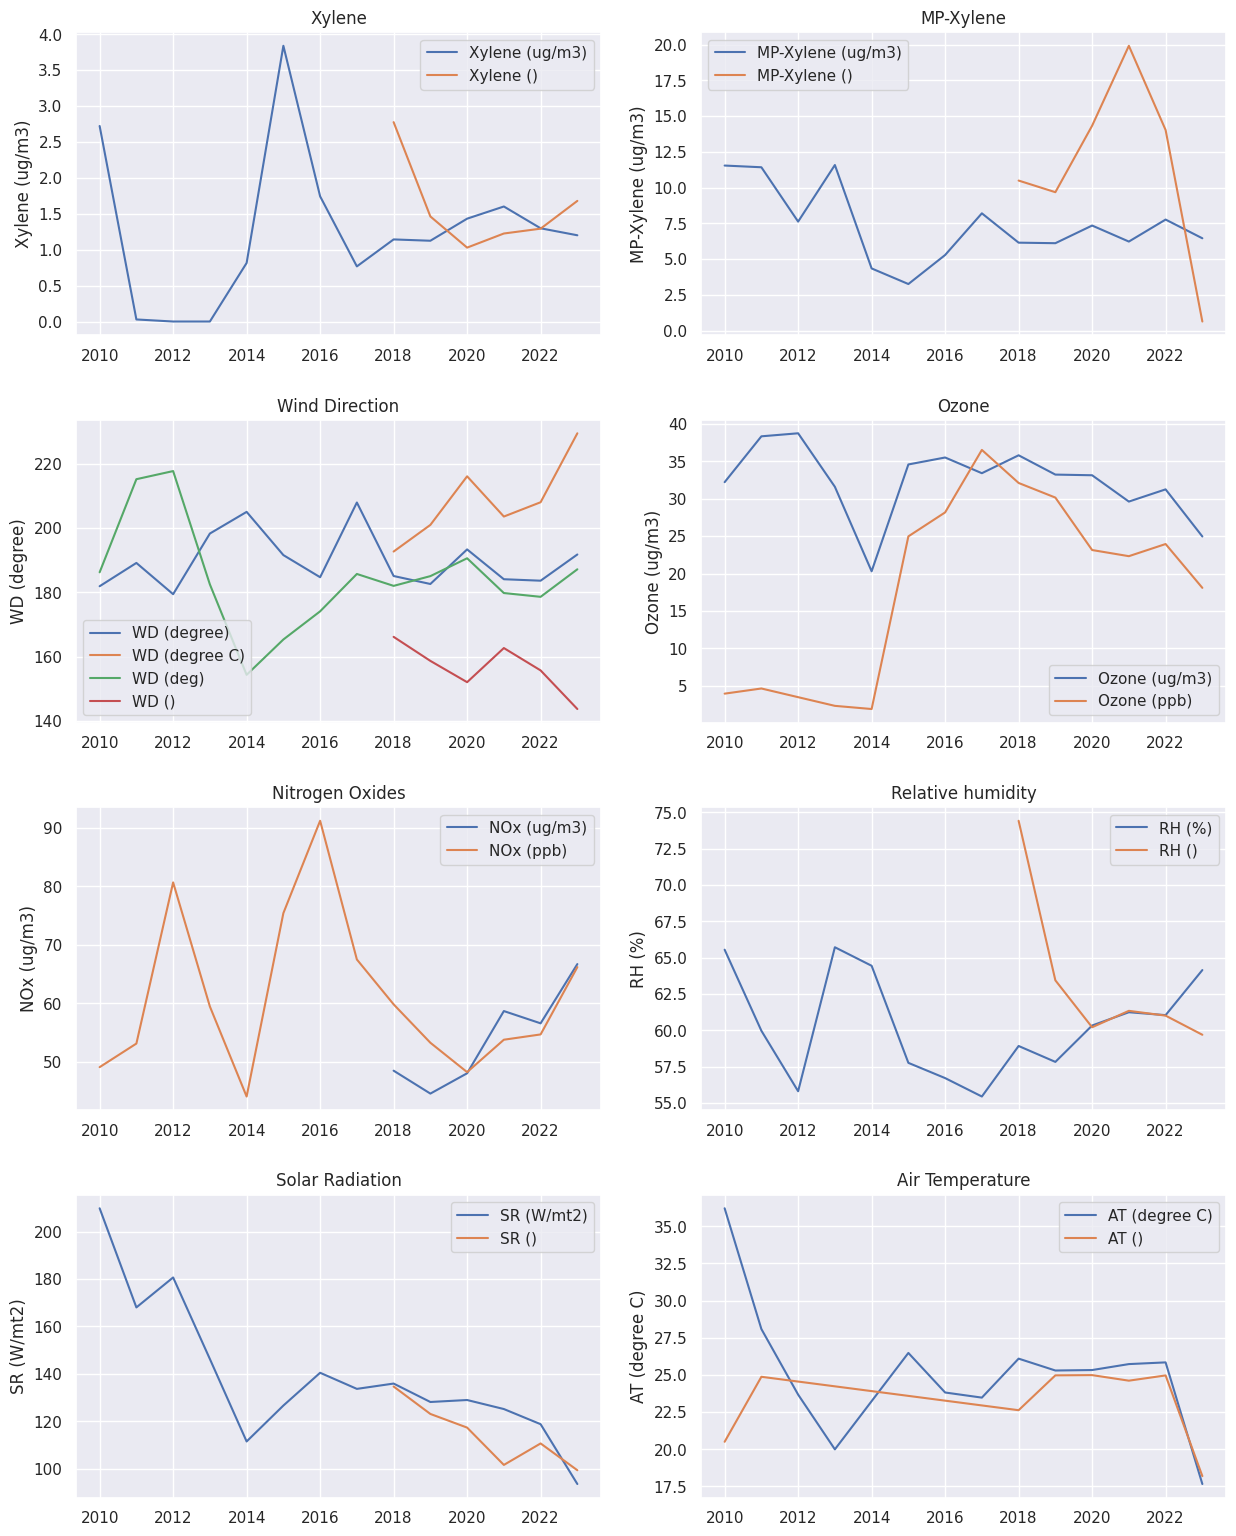

In [13]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':   ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative humidity':  ['RH (%)', 'RH ()'],
    'Solar Radiation': ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':  ['AT (degree C)', 'AT ()']
}

plot_feature_similarities(df, groups, columns=2)

Procediamo quindi con l’analisi descrittiva delle variabili raggruppate. Dopo aver raccolto in un’unica lista tutte le feature interessate, calcolo per ciascuna statistica di base — media, deviazione standard, valori minimo e massimo — formattando i risultati con tre decimali per migliorarne la leggibilità. Questo step permette di valutare rapidamente la scala e la distribuzione delle variabili, facilitando le decisioni su eventuali fusioni o eliminazioni di feature.


In [14]:
all_groups = [item for sublist in list(groups.values()) for item in sublist]
df[all_groups].describe().map(lambda x: f"{x:0.3f}")

,Xylene (ug/m3),Xylene (),MP-Xylene (ug/m3),MP-Xylene (),WD (degree),WD (degree C),WD (deg),WD (),Ozone (ug/m3),Ozone (ppb),NOx (ug/m3),NOx (ppb),RH (%),RH (),SR (W/mt2),SR (),AT (degree C),AT ()
count,242944.000,34578.000,264768.000,29205.000,813361.000,43888.000,655812.000,122463.000,1874697.000,47576.000,86086.000,1876466.000,1611483.000,39722.000,1555347.000,43267.000,1110834.000,83016.000
mean,1.337,1.319,7.040,13.824,186.417,205.871,184.905,157.480,32.370,25.864,52.076,56.894,59.893,62.812,130.106,116.041,25.136,24.178
std,5.762,3.348,13.603,19.986,94.905,88.418,80.286,91.992,34.778,19.535,59.768,70.730,22.548,20.497,180.273,172.197,8.561,8.426
min,0.000,0.000,0.010,0.010,0.020,1.200,0.030,1.300,0.010,0.050,0.100,0.000,0.010,0.820,0.000,2.720,0.100,1.880
25%,0.000,0.000,1.210,2.890,104.850,119.570,121.010,86.950,8.550,13.530,17.380,16.980,43.120,46.450,5.580,3.480,18.580,17.420
50%,0.000,0.400,2.940,7.040,187.380,230.435,185.310,147.830,19.600,20.480,31.050,31.680,61.330,63.820,29.500,11.350,26.400,25.380
75%,1.010,1.400,7.410,15.760,268.950,285.550,252.050,229.700,43.150,33.130,61.100,64.280,78.000,80.000,216.210,174.735,31.500,30.300
max,476.310,231.000,491.510,286.010,360.000,356.520,359.590,359.700,200.000,198.470,498.850,500.000,100.000,99.200,1995.000,836.420,58.900,56.270


Dopo aver esaminato in dettaglio la tabella, avvio la riduzione delle colonne duplicate aggregando quelle che rappresentano la stessa variabile con nomi diversi. Per farlo definisco un dizionario in cui ogni chiave è il nome unificato della variabile e i valori sono le etichette alternative. La funzione itera sul dizionario, trasferendo i valori non nulli dalle colonne secondarie a quella principale e cancellando infine le colonne ridondanti. Questo passaggio semplifica il dataset, eliminando le duplicazioni e facilitando le analisi future.

In [15]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [16]:
def merge_columns(dataframe, columns):
    for column, cols_to_merge in columns.items():
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])

    return dataframe

In [17]:
df = merge_columns(df, reduction_groups)

### Verifica dei valori mancanti

Il primo passo consiste nel quantificare quanti dati mancanti siano presenti per ciascuna delle feature selezionate.

In [18]:
df.isnull().sum().sort_values(ascending=False)

,0
CO2 (mg/m3),2796171
Temp (ug/m3),2796171
NMHC (ug/m3),2796171
Gust (m/s),2796171
Variance (n),2796171
SPM (ug/m3),2796171
Gust (km/hr),2796171
Power (W),2796171
Eth-Benzene (),2796171
Gust (kl/h),2796171


In [19]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [20]:
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percentage of Missing Values (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

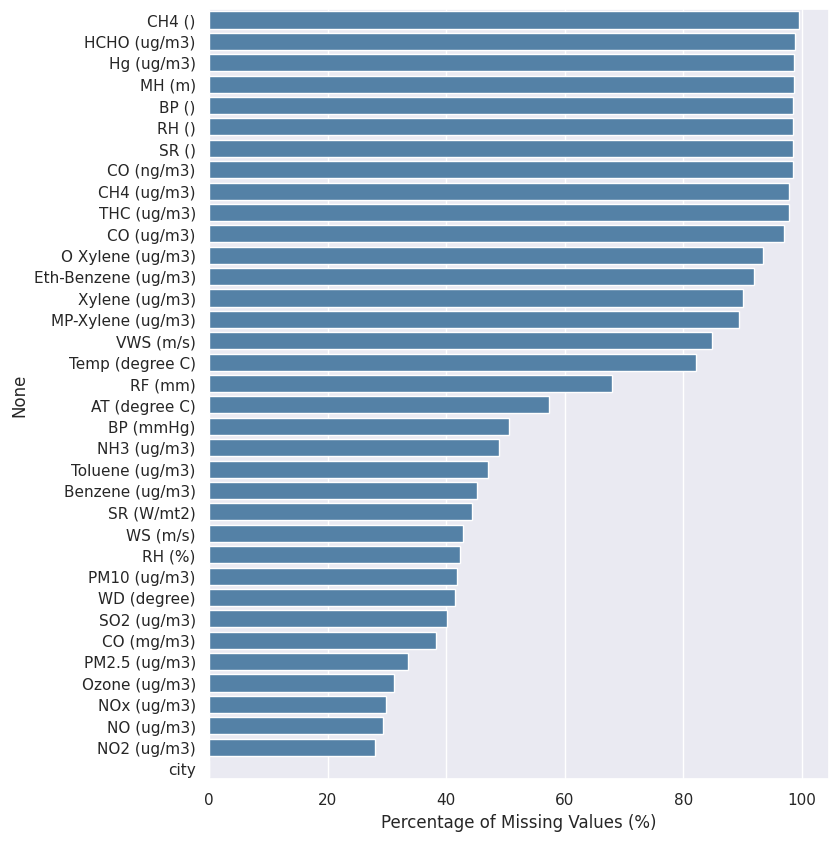

In [21]:
df_null_info = get_null_info(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percentage of Missing Values (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

### Informazioni sul numero dei valori mancanti del dataset

Finora abbiamo analizzato solo un singolo stato. Potremmo avere una migliore percezione dei dati mancanti se analizzassimo l'intero Dataset.

In [22]:
def get_overall_ds_info():
    features = {}
    total_records = 0

    for i, state_name in enumerate(unique_states):
        clear_output(wait=False)

        temp_df = combine_state_df(state_name)
        temp_df = create_dt_index(temp_df)
        temp_df = temp_df.dropna(how='all')

        comparisons = get_null_info(temp_df)

        total_records += df.shape[0]

        for feature in comparisons.index:
            if feature in features:
                features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
            else:
                features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]

    ds_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
    ds_null_info['Percentage of Missing Values (%)'] = round(ds_null_info['Null Count'] * 100 / total_records, 2)
    ds_null_info = ds_null_info.sort_values(by=['Null Count'], ascending=False)
    return ds_null_info

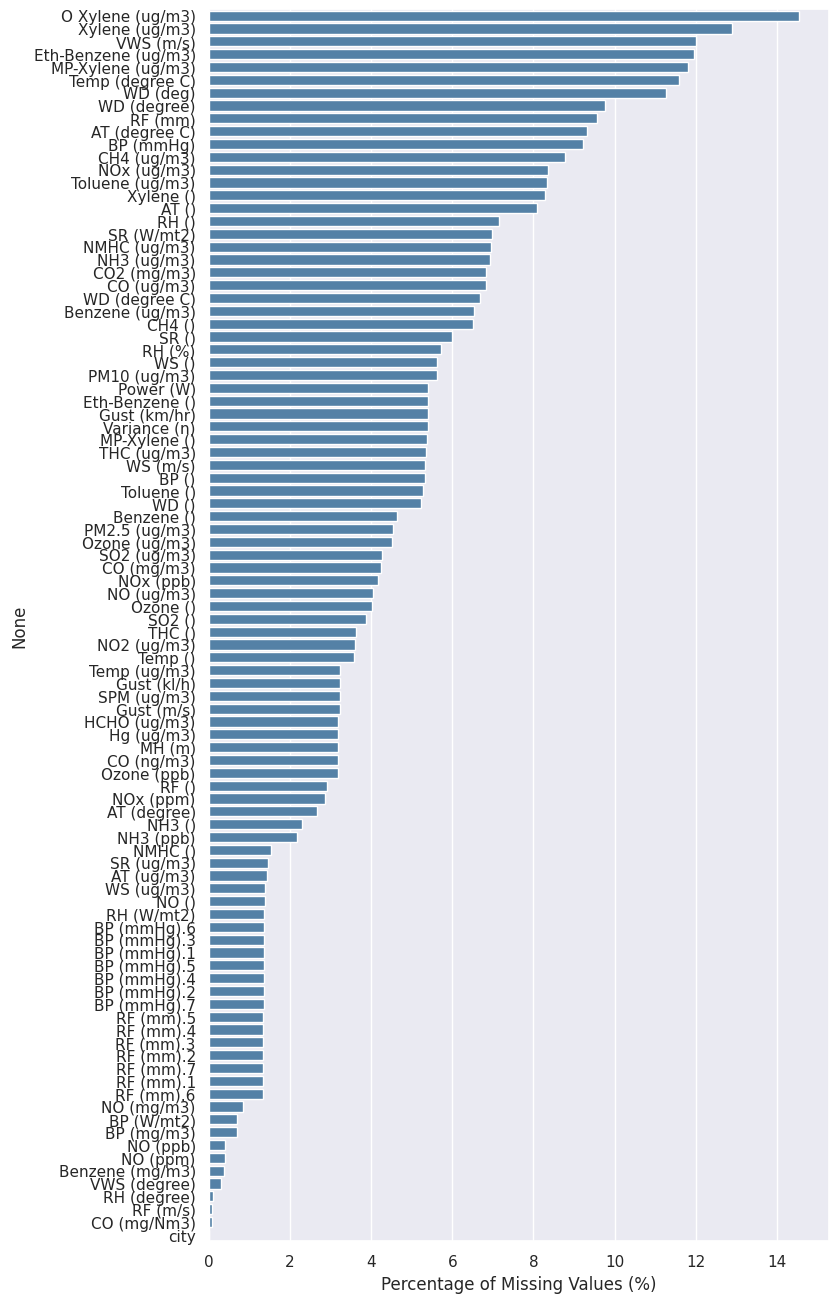

In [23]:
overall_ds_info = get_overall_ds_info()

plt.figure(figsize=(8, 16))
sns.barplot(data=overall_ds_info, x='Percentage of Missing Values (%)', y=overall_ds_info.index, orient='h', color='steelblue')
plt.show()

### Eliminare i valori mancanti per soglia

Tornando al dataframe della capitale Delhi, possiamo eliminare le colonne che contengono una certa soglia (cioè > 40%) di valori mancanti.

In [24]:
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [25]:
get_null_info(df)

,Null Count,Percentage of Missing Values (%)
CO (mg/m3),1070972,38.30
PM2.5 (ug/m3),939895,33.61
Ozone (ug/m3),873898,31.25
NOx (ug/m3),833619,29.81
NO (ug/m3),821483,29.38
NO2 (ug/m3),783452,28.02
city,0,0.00


### Analisi esplorativa dei dati

Sto raccogliendo le metriche iniziali in diversi gruppi. Ciò consentirà di effettuare confronti migliori.

In [26]:
pollutants = {
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],
    'Carbon Monoxide': ['CO (mg/m3)'],
    'Sulfur Dioxide': ['SO2 (ug/m3)'],
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    'Solar Radiation' : ['SR (W/mt2)'],
    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],
    'Relative Humidity' : ['RH (%)'],
    'Rainfall' : ['RF (mm)'],
    'Barometric Pressure' : ['BP (mmHg)'],
    'Wind Direction' : ['WD (degree)'],
    'Wind Speed' : ['WS (m/s)']
}

### Frequenze temporali

Cominciamo a raggruppare il nostro DataFrame per varie frequenze temporali.

In [27]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1ME')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1YE')).mean(numeric_only=True)
}

In [28]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]

            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

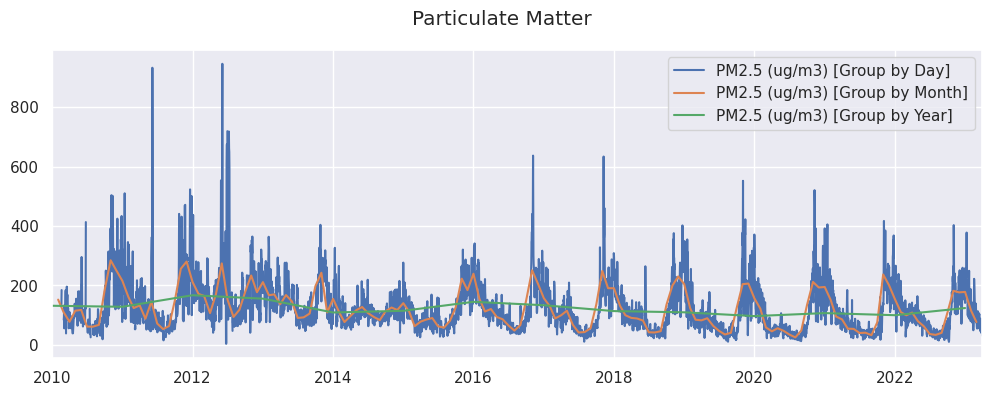

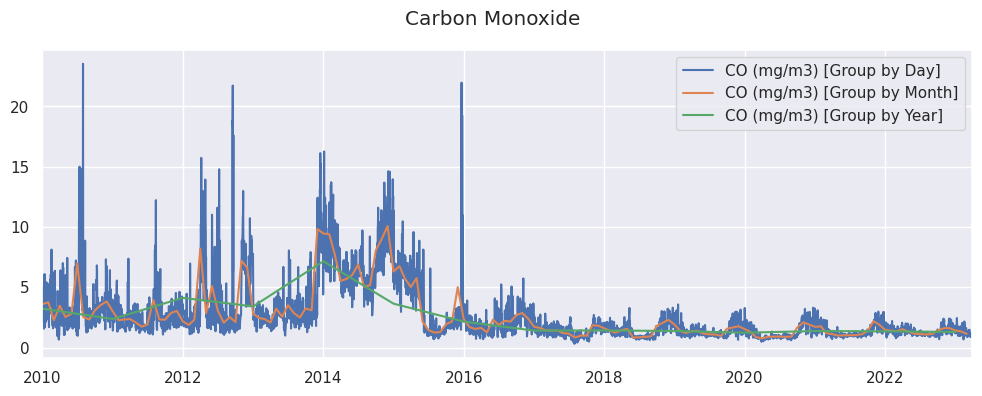

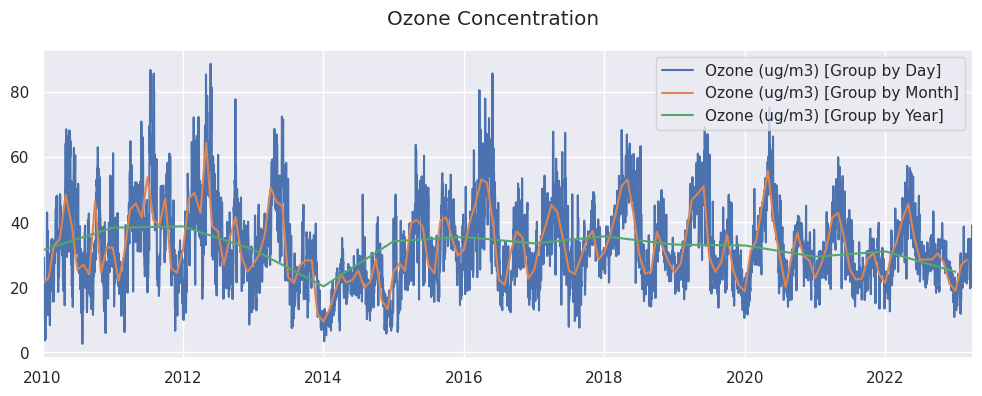

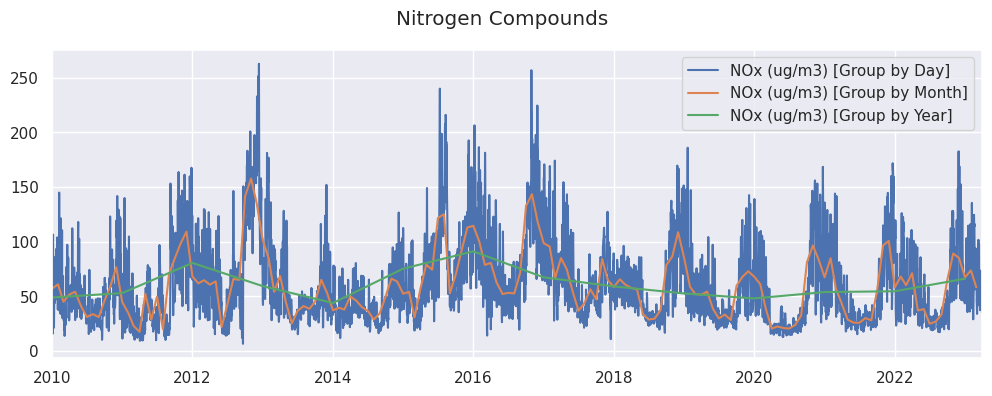

In [29]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

### Analisi stagionale su base annua
Dalle metriche selezionate emergono potenziali pattern di tipo stagionale. Per approfondire questa osservazione, eseguiamo un’analisi dettagliata delle variazioni stagionali nell’arco di un anno. Come punto di partenza, prenderemo in considerazione un sottoinsieme di dati relativo al periodo 2019–2020.

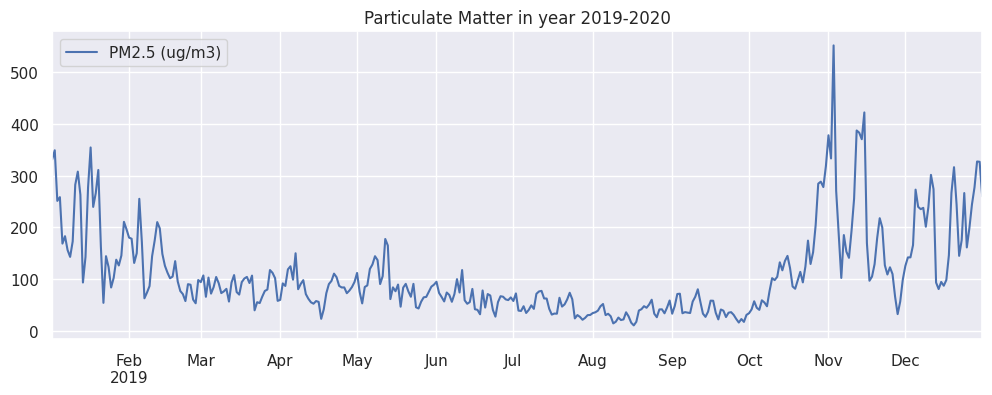

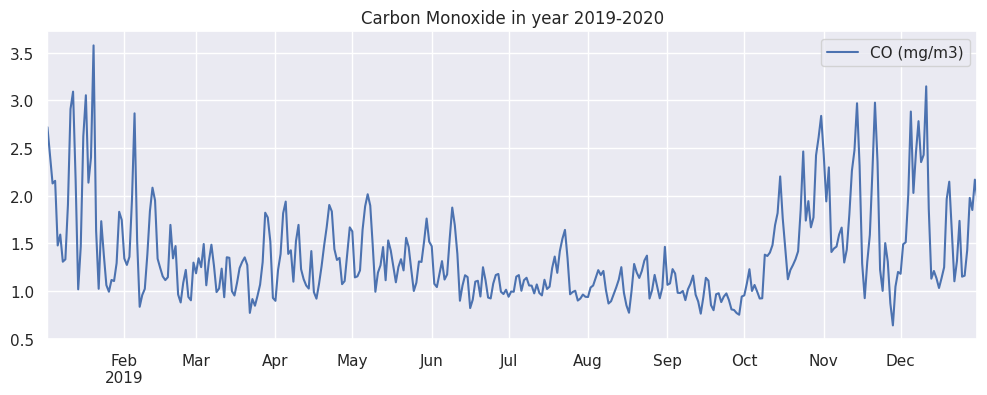

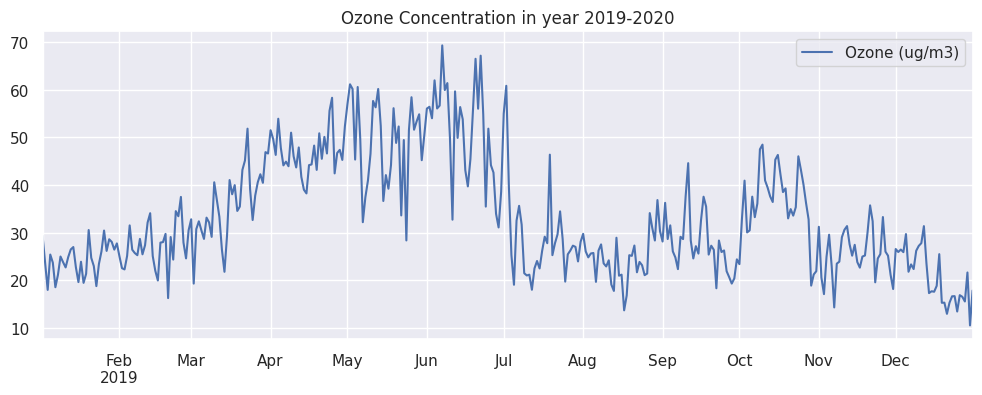

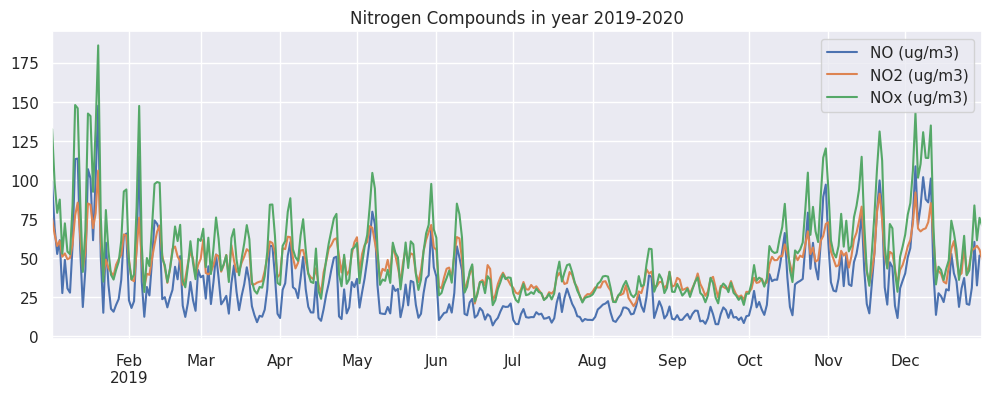

In [30]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2019 and datetime < 2020').plot(title=f'{feature} in year 2019-2020', figsize=(12,4)).set(xlabel=None)

Si osserva un incremento nei valori di `Particulate Matter`, `Nitrogen Compounds` e `Carbon Monoxide` a partire da ottobre, con un picco che tende a persistere fino circa a marzo. Al contrario, la `Ozone Concentration` mostra un comportamento opposto, raggiungendo i valori massimi indicativamente tra maggio e giugno.

### PairPlot
Andiamo ad utilizzare il grafico a coppie, che ci consente di visualizzare in modo più chiaro le relazioni bivariate tra le variabili, nonché la distribuzione univariata di ciascuna di esse.

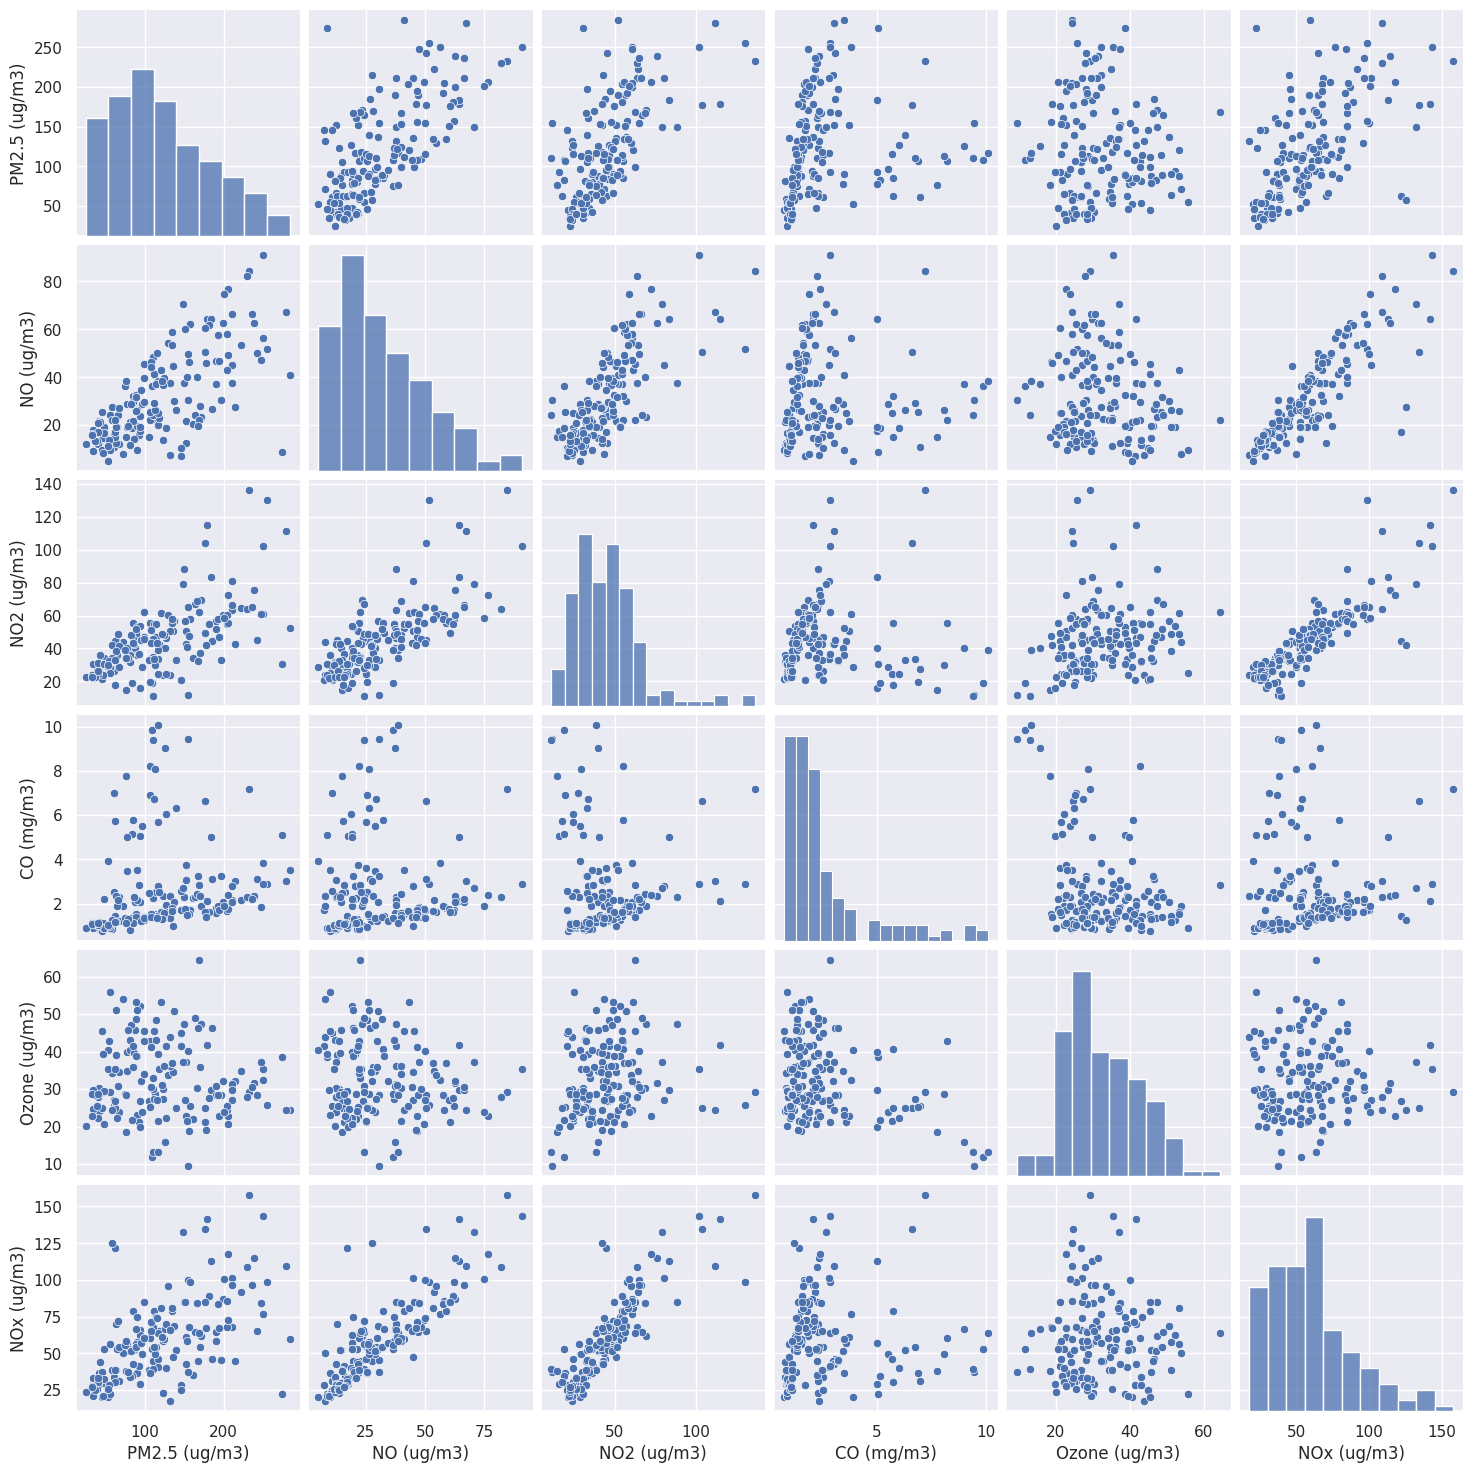

In [31]:
sns.pairplot(slice_groups['Group by Month'])

È evidente una correlazione lineare significativa tra `NOx`, `NO` e `NO2`. Considerando questa relazione, può essere opportuno mantenere esclusivamente la variabile aggregata `NOx` come rappresentazione generale del gruppo.

### Matrice di correlazione
Ora, andiamo ad utilizzare la matrice di correlazione che offre una rappresentazione sintetica ed efficace del grado di associazione lineare tra le diverse variabili del dataset.

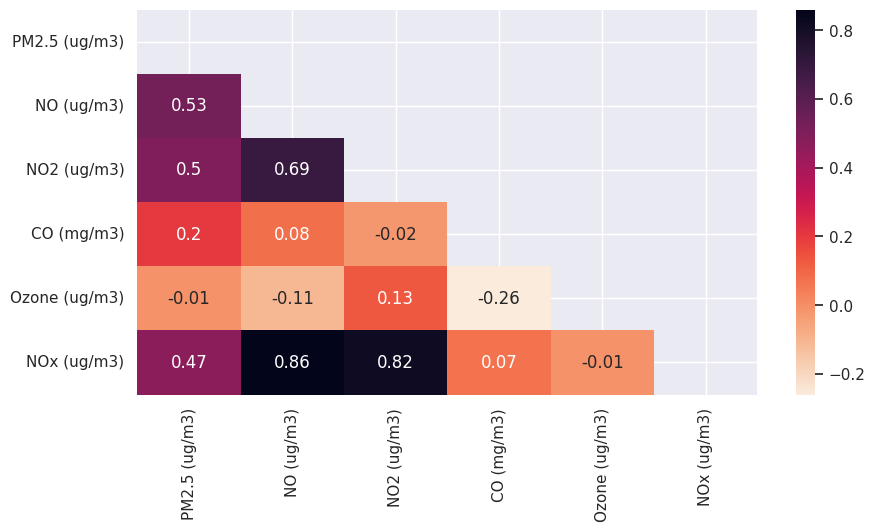

In [32]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [33]:
corr_target = abs(corr['PM2.5 (ug/m3)'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

,PM2.5 (ug/m3)
PM2.5 (ug/m3),1.00
NO (ug/m3),0.53
NO2 (ug/m3),0.50
NOx (ug/m3),0.47


Il grafico evidenzia diverse correlazioni significative tra le variabili. In particolare:

- `NOx` mostra una forte correlazione con le variabili `NO` e `NO2`.
- È inoltre evidente una relazione positiva tra `PM2.5` e `NOx`, suggerendo che all’aumentare dei valori di `NOx`, tendono ad aumentare anche i livelli di `PM2.5`.

## Feature Engineering

### Eliminazione delle Feature correlate

In [34]:
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

### Resampling
Poiché il dataframe combinato include misurazioni provenienti da diverse località all'interno dello stesso stato e riferite agli stessi intervalli temporali, è possibile che si verifichino duplicazioni temporali. Dal momento che l’obiettivo è analizzare la qualità dell’aria a livello statale, procederemo con un ricampionamento temporale aggregando i dati mediante media delle misurazioni corrispondenti allo stesso timestamp.

In [35]:
df = df.resample('60min').mean(numeric_only=True)

### Rilevamento e rimozione degli outlier
Gli outlier rappresentano valori anomali che si discostano in modo significativo dalla distribuzione generale dei dati. La loro presenza può compromettere l’accuratezza delle analisi statistiche e influenzare negativamente le prestazioni dei modelli predittivi. L’identificazione e la rimozione degli outlier consente di ottenere risultati più affidabili e modelli previsionali più robusti.

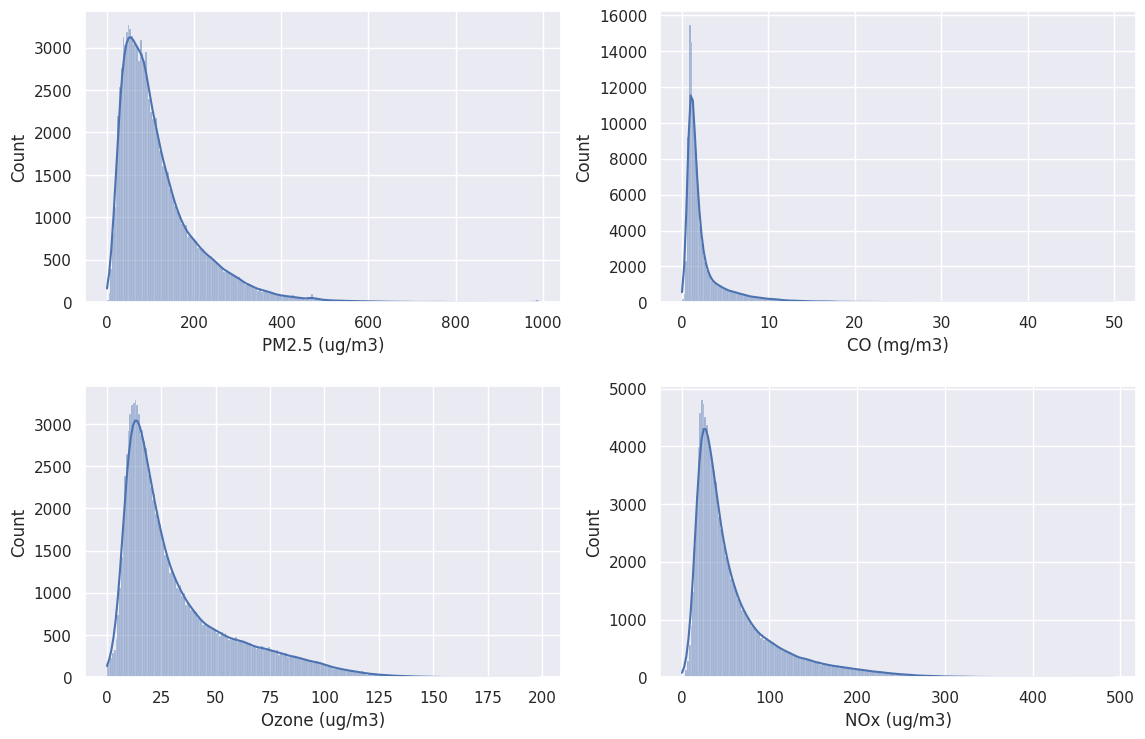

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

sns.histplot(data=df['PM2.5 (ug/m3)'], bins=250, kde=True, ax=axes[0,0])
sns.histplot(data=df['CO (mg/m3)'], bins=250, kde=True, ax=axes[0,1])
sns.histplot(data=df['Ozone (ug/m3)'], bins=250, kde=True, ax=axes[1,0])
sns.histplot(data=df['NOx (ug/m3)'], bins=250, kde=True, ax=axes[1,1])

plt.show()

La prima feature che esploreremo è il `PM2,5`.

<Axes: xlabel='datetime'>

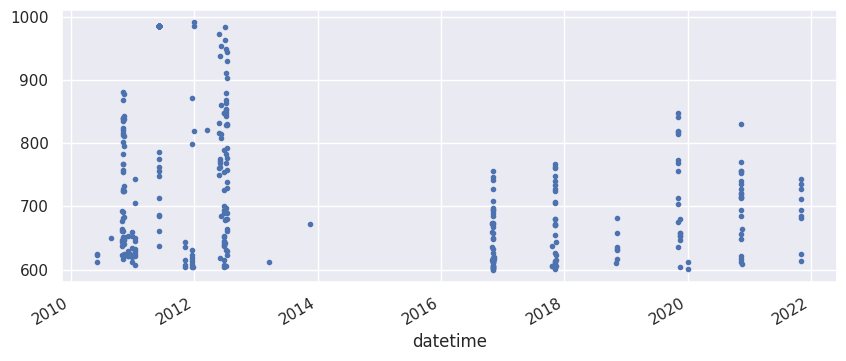

In [37]:
df.query('`PM2.5 (ug/m3)` > 600')['PM2.5 (ug/m3)'].plot(style='.', figsize=(10,4))

Si osserva la presenza di alcuni outlier con valori superiori a 950, concentrati intorno all’anno 2012. Considerata la loro natura anomala, si procede con la loro rimozione al fine di migliorare la qualità dell’analisi.

In [38]:
df['PM2.5 (ug/m3)'] = df['PM2.5 (ug/m3)'].mask(df['PM2.5 (ug/m3)'].gt(950))

Successivamente, esploriamo i potenziali outlier sulla feature del `CO`.

<Axes: xlabel='datetime'>

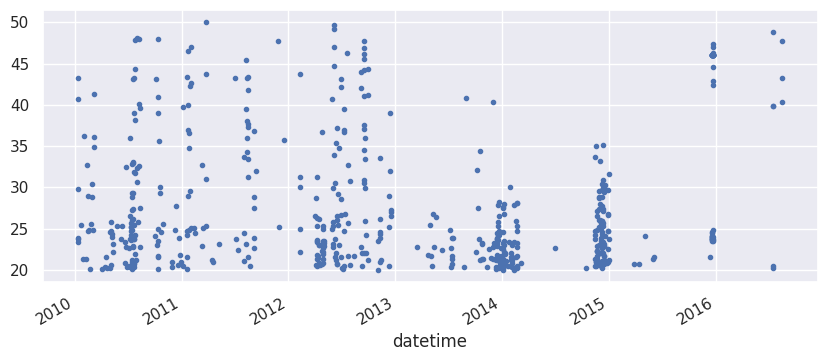

In [39]:
df.query('`CO (mg/m3)` > 20')['CO (mg/m3)'].plot(style='.', figsize=(10,4))

Si può notare una significativa variabilità in questa feature. Tuttavia, un gruppo situato sulla parte destra del grafico, dopo l'anno 2015, ha suscitato il nostro interesse. Pertanto, optiamo per escluderlo.

In [40]:
df['CO (mg/m3)'] = df['CO (mg/m3)'].mask(((df.index > '2015') & df['CO (mg/m3)'].gt(35)))

Esploriamo anche la feature dell' `Ozone`.

<Axes: xlabel='datetime'>

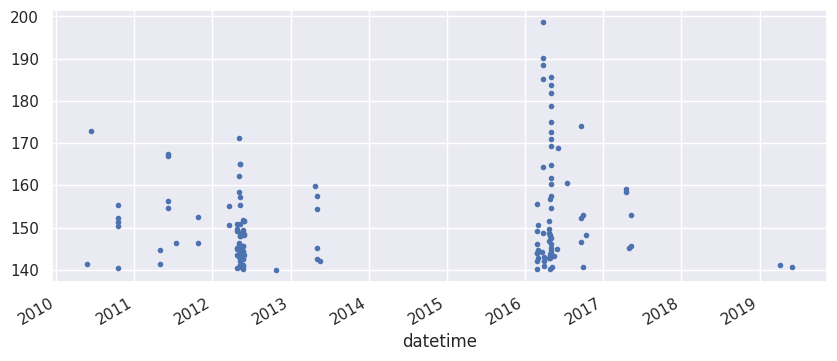

In [41]:
df.query('`Ozone (ug/m3)` > 140')['Ozone (ug/m3)'].plot(style='.', figsize=(10,4))

Gli outliers sembrano essere presenti esclusivamente nella metà del 2016. Pertanto, procederemo con la rimozione di questi valori anomali relativi a tale periodo.

In [42]:
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].mask(df['Ozone (ug/m3)'].gt(185))

Infine, diamo un'occhiata alla feature `NOx`.

<Axes: xlabel='datetime'>

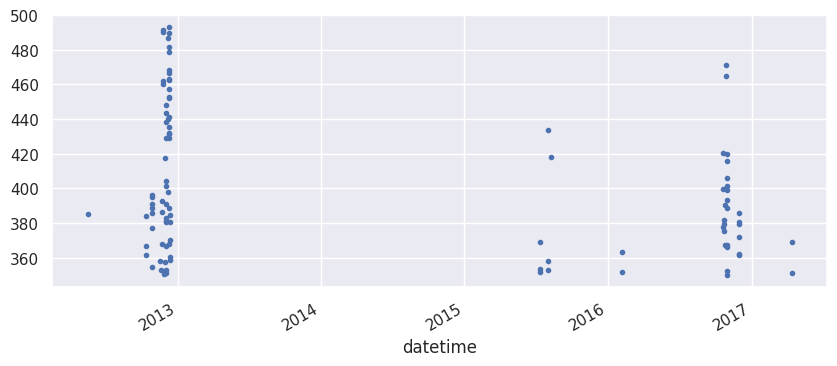

In [43]:
df.query('`NOx (ug/m3)` > 350')['NOx (ug/m3)'].plot(style='.', figsize=(10,4))

Anche in questa situazione, osserviamo solo alcuni outliers che sembrano essere misurazioni errate. Decidiamo quindi di eliminarli.

In [44]:
df['NOx (ug/m3)'] = df['NOx (ug/m3)'].mask((
    ((df.index < '2013') & (df['NOx (ug/m3)'].gt(380))) |
    ((df.index > '2015') & (df.index < '2016') & (df['NOx (ug/m3)'].gt(400))) |
    ((df.index > '2016') & (df['NOx (ug/m3)'].gt(450)))
))

### Gestione dei valori mancanti

In [45]:
get_null_info(df)

,Null Count,Percentage of Missing Values (%)
PM2.5 (ug/m3),3908,3.37
CO (mg/m3),2123,1.83
NOx (ug/m3),104,0.09
Ozone (ug/m3),67,0.06


In [46]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Freq: 60min
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  116112 non-null  float64
 1   CO (mg/m3)     116112 non-null  float64
 2   Ozone (ug/m3)  116112 non-null  float64
 3   NOx (ug/m3)    116112 non-null  float64
dtypes: float64(4)
memory usage: 4.4 MB


<ipython-input-46-0620f09ed20c>:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='pad')


### Arricchimento del Dataset con Caratteristiche Aggiuntive
Procediamo con l'ampliamento del nostro dataset, integrando nuove features che possano risultare utili.

In [47]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [48]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = create_features(df)

Ora, grazie alle features precedentemente descritte, è semplice visualizzare le diverse metriche. Ad esempio, possiamo esaminare la qualità dell'aria nel corso dei mesi utilizzando un boxplot.

In [49]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df, x=time_group, y=metric, hue=time_group, palette="icefire", showfliers=False, legend=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

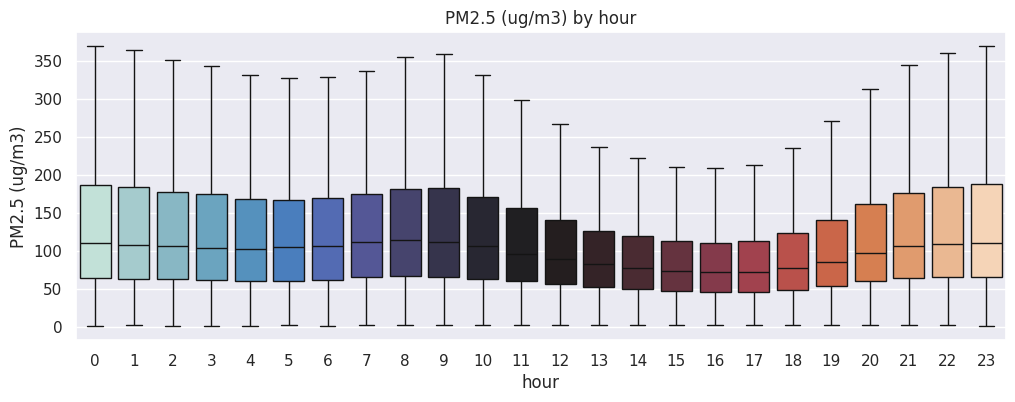

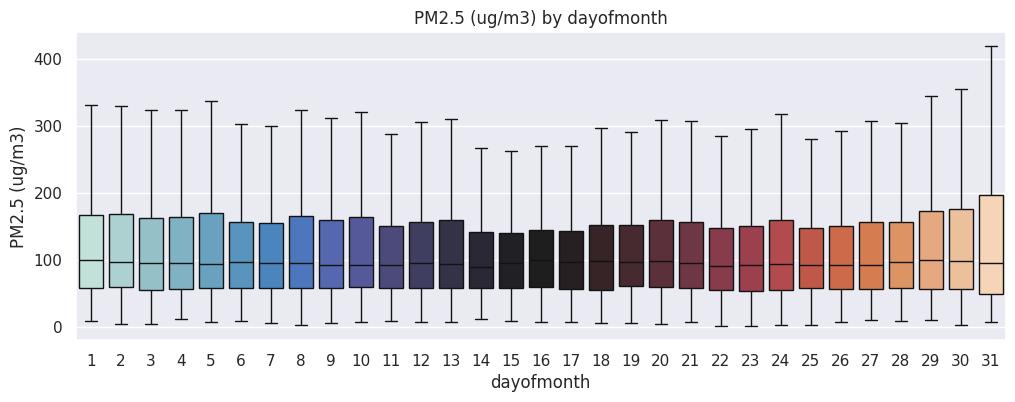

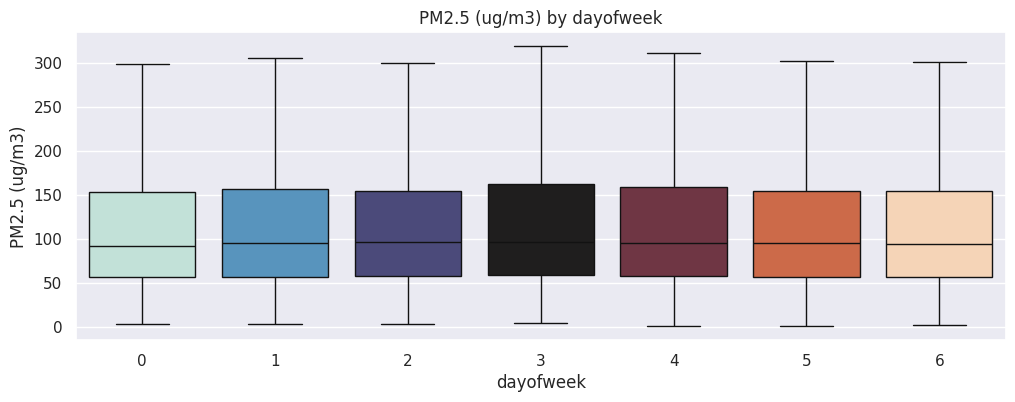

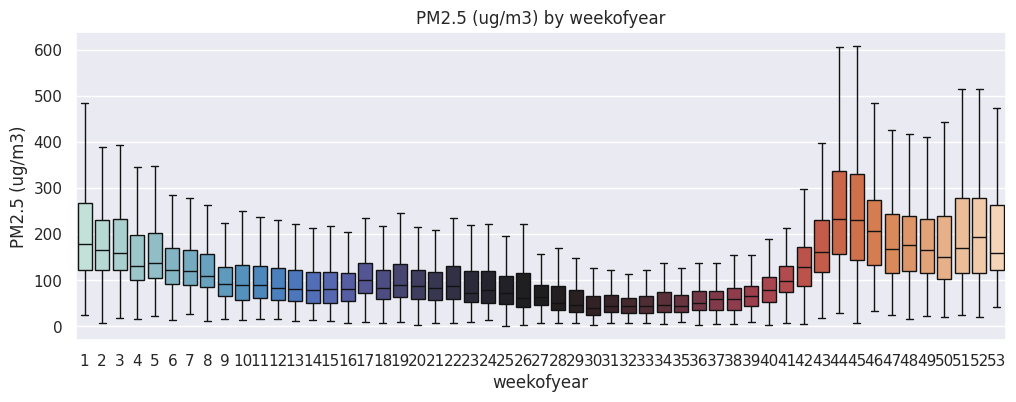

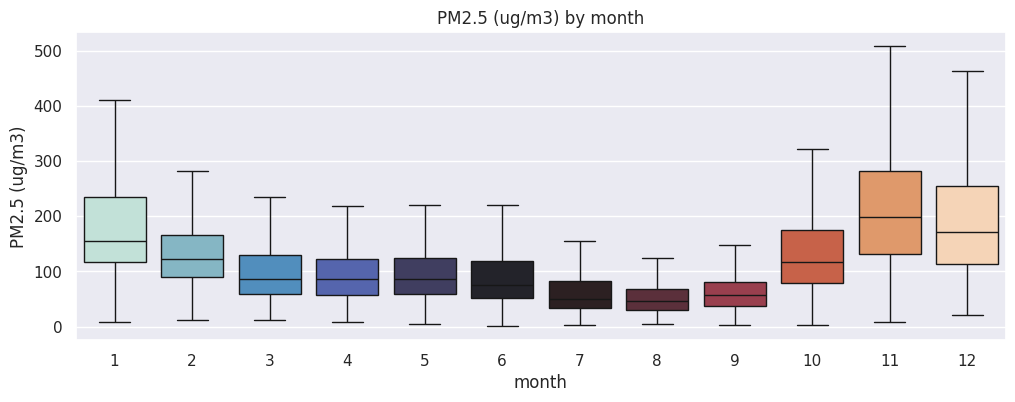

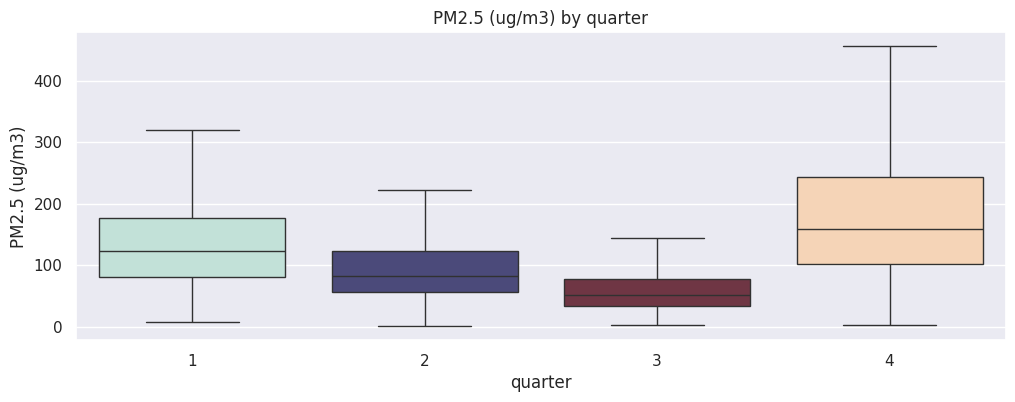

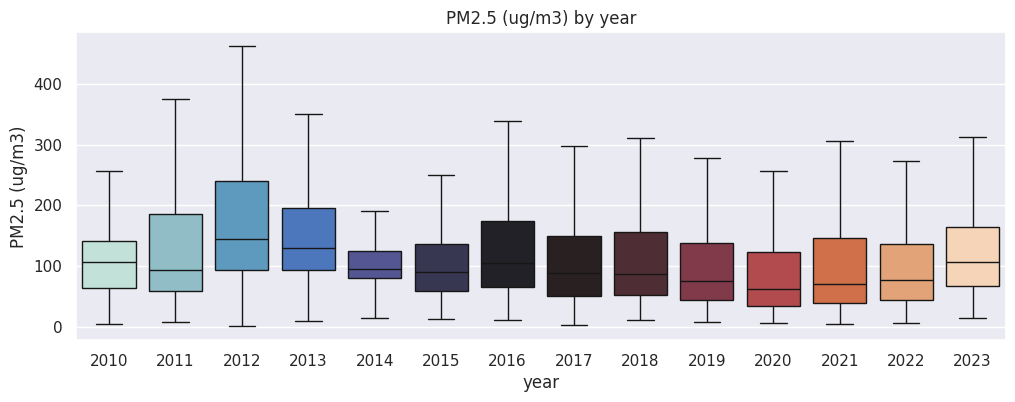

In [50]:
plot_by_datetime('PM2.5 (ug/m3)', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

I grafici mostrano chiaramente che i vari gruppi di date catturano tendenze e informazioni significative. Un punto interessante è che il vettore di feature `dayofweek` potrebbe non essere così rilevante, dato che la distribuzione appare simile per tutti i giorni della settimana. Tuttavia, includeremo comunque tutte queste informazioni nel nostro modello.

### Lag Features

Le cosiddette “lag features” consentono di includere nei modelli i valori storici di una variabile, risultando spesso determinanti nelle previsioni grazie al loro elevato potere predittivo. Possiamo inoltre generare lag anche per altre variabili significative, ampliando il contesto informativo del dataset e potenzialmente migliorando la precisione delle stime.

Analizzando i boxplot, abbiamo osservato che alcune feature evidenziano trend stagionali o andamenti rilevanti nel tempo. Sulla base di queste evidenze, creeremo lag features mirate per sfruttare al meglio tali pattern.

In [51]:
def create_lag_features(df):
    df = df.copy()
    df['pm_lag_1Y'] = df['PM2.5 (ug/m3)'].shift(365*24)   # 1 year lag
    df['pm_lag_2Y'] = df['PM2.5 (ug/m3)'].shift(730*24)   # 2 year lag
    return df

In [52]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y']
df = create_lag_features(df)
df.head()

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,pm_lag_1Y,pm_lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.404029,2.340000,26.0650,73.7425,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.404029,2.327500,20.3425,36.0000,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.404029,2.177500,11.0650,27.1900,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.404029,1.992500,18.4625,21.1125,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.404029,2.096667,13.7500,23.1550,4,1,4,1,53,1,1,2010,NaN,NaN


A seguito della creazione delle lag features, riscontriamo che i primi record del dataset presentano valori mancanti: ciò è inevitabile, dato che non esistono dati storici precedenti per calcolare i ritardi temporali. È quindi fondamentale gestire con cura questi missing values, poiché molti algoritmi predittivi non possono elaborare dati incompleti. Per affrontare questo problema, implementeremo una funzione dedicata al trattamento dei NaN generati dai lag, tenendo presente che questa operazione, pur necessaria per confrontare le performance dei modelli, potrebbe introdurre bias o comportare la perdita di informazioni nei periodi iniziali di raccolta.

In [53]:
def replace_lag_na(df, how):
    if how == 'zeros':
        return df.fillna(0)
    if how == 'drop':
        return df.dropna(how='any')